In [1]:
import os
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import random
# import pyspark
# from pyspark.sql import SparkSession

### Read JSON from URL

In [2]:
def read_json_sampling(url, chunk_size, sample_size, random_state=None):
    """
    Reads a JSON file in chunks, samples from each chunk, and returns a combined sample.

    Args:
        url (str): JSON file url
        chunk_size (int): Number of rows to read in each chunk.
        sample_size (int): Total number of rows to sample.
        random_state (int, optional): Seed for random sampling. Defaults to None.

    Returns:
        pd.DataFrame: A DataFrame containing the sampled rows.
    """
    if random_state is not None:
        random.seed(random_state)

    sampled_chunks = []
    total_rows = 0

    for chunk in pd.read_json(url, lines=True, chunksize=chunk_size):
       
        chunk_sample_size = min(sample_size - total_rows, len(chunk))
        if chunk_sample_size > 0:
            sampled_chunk = chunk.sample(n=chunk_sample_size, random_state=random_state)
            sampled_chunks.append(sampled_chunk)
            total_rows += chunk_sample_size
        if total_rows >= sample_size:
            break

    return pd.concat(sampled_chunks, ignore_index=True)

#### Json from Local

In [3]:
# url_reviews = '/../data/Appliances.jsonl.gz'
# url_meta= '../../data/meta_Appliances.jsonl.gz'

#### Json from URL

In [4]:
# # Appliances
# url_reviews = 'https://mcauleylab.ucsd.edu:8443/public_datasets/data/amazon_2023/raw/review_categories/Appliances.jsonl.gz'
# url_meta = 'https://mcauleylab.ucsd.edu:8443/public_datasets/data/amazon_2023/raw/meta_categories/meta_Appliances.jsonl.gz'

# Music
# url_reviews = 'https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/review_categories/Digital_Music.jsonl.gz'# df_ratings = None
# url_meta = 'https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/meta_categories/meta_Digital_Music.jsonl.gz'

In [5]:
# df_meta = read_json_sampling(url_meta, 1000, 100000, 33)

In [6]:
# df_ratings = read_json_sampling(url_reviews, 1000, 200000, 33)

#### Backup full file

In [7]:
# df_meta_full = df_meta.copy(deep=True)
# df_ratings_full = df_ratings.copy(deep=True)

In [8]:
# Try- For resetting display 
pd.options.display.max_colwidth = 50

##### Park - Downsizing Samples

Due to limited computing power and resource constraints, the each dataset is downsized by x%

In [9]:
# n_pct_ratings = 0.05
# n_pct_meta = 0.2

# pct_ratings = int(round(n_pct_ratings*len(df_ratings), 0))
# pct_meta = int(round(n_pct_meta*(len(df_meta)), 0 ))

In [10]:
# df_meta = df_meta.sample(pct_meta, random_state=33)
# df_ratings = df_ratings.sample(pct_ratings, random_state=33)

### Dummy Test: Override auto load with manual dummy file test

In [11]:
dummy_ratings = ('../data/raw/dummy_ratings.jsonl.gz')
dummy_meta = ('../data/raw/dummy_meta.jsonl.gz') 

In [12]:
df_meta = pd.read_json(dummy_meta)
df_ratings = pd.read_json(dummy_ratings)

In [13]:
df_meta.reset_index(drop=True, inplace=True)
df_ratings.reset_index(drop=True, inplace=True)

## DATA CLEANING

#### Cleaning META

In [14]:
# Verify shape
df_meta.shape

(30, 16)

In [15]:
# Verify dtypes
df_meta.dtypes

main_category       object
title               object
average_rating     float64
rating_number        int64
features            object
description         object
price              float64
images              object
videos              object
store               object
categories          object
details             object
parent_asin         object
bought_together    float64
subtitle           float64
author             float64
dtype: object

In [16]:
# Verify columns 
df_meta.columns

Index(['main_category', 'title', 'average_rating', 'rating_number', 'features',
       'description', 'price', 'images', 'videos', 'store', 'categories',
       'details', 'parent_asin', 'bought_together', 'subtitle', 'author'],
      dtype='object')

<div class="alert alert-block alert-warning">
Decide which columns to drop
</div>

In [17]:
# Drop columns that are not needed in the analysis

# Images and videos won't be utilized in the analysis
# Price is not needed for this analysis so we drop it for now. 
# Average_rating and rating number can be dropped as well 


cols_to_drop = [ 'average_rating', 'rating_number', 'price', 'images', 'videos', 'bought_together', 'subtitle', 'author']
df_meta.drop( cols_to_drop, axis=1, inplace=True )


In [18]:
# Verify: After dropping columns. df_meta types and counts
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   main_category  30 non-null     object
 1   title          30 non-null     object
 2   features       30 non-null     object
 3   description    30 non-null     object
 4   store          30 non-null     object
 5   categories     30 non-null     object
 6   details        30 non-null     object
 7   parent_asin    30 non-null     object
dtypes: object(8)
memory usage: 2.0+ KB


In [19]:
# Dealing with empty lists in columns:

# Get % of empty lists [] in cols of interest.
# Delete column if it exceeds threshold values - separate this functionality

threshold = 0.25
cols_of_interest = ['features', 'description', 'categories'] #-- Exclude description as it can be used in feature groups down the line.

for col in cols_of_interest:

    pct = sum(~df_meta[col].astype(bool)) / len(df_meta)
    print(f'Empty [{col}] : {100*pct:.2f}%')
    
    # # Drop column if it exceeds threshold value for empty list
    # if pct >= threshold:
    #     df_meta.drop(col, axis=1, inplace=True)


Empty [features] : 20.00%
Empty [description] : 43.33%
Empty [categories] : 6.67%


In [20]:
# Verify: No null columns in meta
df_meta.isna().sum()

main_category    0
title            0
features         0
description      0
store            0
categories       0
details          0
parent_asin      0
dtype: int64

In [21]:
# Fill null values, as needed. 
df_meta.store.fillna('Undescribed', inplace=True)
df_meta.main_category.fillna('Uncategorized', inplace=True)

/tmp/ipykernel_42488/1379288898.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_meta.store.fillna('Undescribed', inplace=True)
/tmp/ipykernel_42488/1379288898.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

In [22]:
# UT: No null columns in meta
df_meta.isna().sum()

main_category    0
title            0
features         0
description      0
store            0
categories       0
details          0
parent_asin      0
dtype: int64

In [23]:
# Verify shape after cleaning steps
df_meta.shape

(30, 8)

#### Cleaning RATINGS

In [24]:
# Verify shape
df_ratings.shape

(5547, 10)

In [25]:
# Verify dtypes
df_ratings.dtypes

rating                        int64
title                        object
text                         object
images                       object
asin                         object
parent_asin                  object
user_id                      object
timestamp            datetime64[ns]
helpful_vote                  int64
verified_purchase              bool
dtype: object

In [26]:
# Verify dataset
df_ratings.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,I am AMAZED to See Bad Reviews.,I came here to post a review because these are...,[],B00LGEKOMS,B07RNJY499,AEDTXOC3YW6O7P2UPM22VNNRF77A,2020-10-16 20:26:21.427,0,True
1,5,Works well,Happy with product,[],B01DP1IWKU,B092LLM7H3,AE6DFDMIJAVW57EVMRJH2M2X6ACA,2021-12-01 22:22:40.165,1,True
2,4,Four Stars,This works well.,[],B000DLB2FI,B000DLB2FI,AEVGR67KN3CT4TO5D6HO3WNZGRPA,2015-02-27 12:51:16.000,0,True
3,5,Five Stars,GREAT,[],B0001IRRLQ,B0BHNSLKNZ,AFLEUJNQJQOYOYDUJ2PSZ4O2TUJA,2015-11-07 03:54:08.000,0,True
4,5,Savings,"Exelent, save on coffee, water, no waste, e...",[],B00LGEKOMS,B07RNJY499,AEOVCZC77QZJQPBIAIKCFV7AS7PA,2017-10-16 22:46:40.529,0,True


In [27]:
# Drop columns that are not needed in the analysis
cols_to_drop = ['title', 'text', 'images', 'helpful_vote', 'timestamp', 'verified_purchase' ]

# Drop columns
df_ratings.drop(cols_to_drop, axis=1, inplace=True)

In [28]:
# UT: No null columns in df_ratings
df_ratings.isna().sum()

rating         0
asin           0
parent_asin    0
user_id        0
dtype: int64

## EDA

#### Merging meta and reviews

In [29]:
# Merge metadata and reviews dataset
df = pd.merge(df_meta, df_ratings, how='left', on='parent_asin')

In [30]:
# Verify shape
df.shape

(5567, 11)

In [31]:
# Verify null columns
df.isna().sum()

main_category     0
title             0
features          0
description       0
store             0
categories        0
details           0
parent_asin       0
rating           20
asin             20
user_id          20
dtype: int64

In [32]:
# Show no. of null rows. 
print(f'Percentage of Blank [Store] rows : { round(100 * df.store.isna().sum() / len(df), 2) } % -> Fill' ) 

Percentage of Blank [Store] rows : 0.0 % -> Fill


##### Try: Find unrated items

[asin] represents a variant of a parent product. The granularity of evaluating a product rating should be in terms of its variant and not its parent [parent_asin].\
The [parent_asin] can be dropped. 

Find which records in df_meta were not in df_ratings

In [33]:
df_unrated = df[df.rating.isna()]
df_unrated[['parent_asin', 'title']]

,parent_asin,title
5547,B07S9DJ2S2,"Frigidaire Portable Compact Maker, Counter Top..."
5548,B07QZHQTVJ,Whirlpool W10918546 Igniter
5549,B0BC65XJLJ,"W10295370A Water FiIter Cap Replacement, Compa..."
5550,B08VHW1WQW,Supplying Demand WR9X520 WR09X0520 Refrigerato...
5551,B09YRPT4Q2,"BELVITA ADQ747935 Water Filter Replacement,Com..."
5552,B0B5V1VTX1,MANWU 2 sets flame indicators ring stove stick...
5553,B00LOX5BNS,General Electric WH02X10093 Ring Compression
5554,B07L4HVLZJ,2pc WD24X10018 - Piston and Nut Assembly for G...
5555,B078RCY7SQ,"Compatible Door Bin for Frigidaire FRS26R2AW6,..."
5556,B01N638EFK,Shark XHF350 Navigator Lift Away NV350 NV351 N...


<div class="alert alert-block alert-warning">
Decide whether to drop the null ASINs or unreviewed ASINS ( meaning exists in meta but not in reviews)
</div>

#### Summary Statistics

In [34]:
# Info on counts

# n_products_pasin = df.parent_asin.nunique()

n_products = df.asin.nunique()
n_titles = df.title.nunique()
n_ratings = len(df.rating)
n_users = df.user_id.nunique()

# print(f'Total unique parent products: {n_products_pasin}')
print(f'Total unique products: {n_products}')
print(f'Total unique product name: {n_titles}')
print(f'Total ratings: {n_ratings}')
print(f'Total unique users: {n_users}')

Total unique products: 27
Total unique product name: 30
Total ratings: 5567
Total unique users: 5363


> Note: ASIN is used as the main identifier in the analysis as it corresponds to the specific product variant that HAS BEEN RATED.

In [35]:
# Summary Statistics
avg_rating_p_product = round(n_ratings/n_products, 2)
avg_rating_p_user = round(n_ratings/n_users, 2)

print(f'Average no. of ratings per product: {avg_rating_p_product}')
print(f'Average no. of ratings per user: {avg_rating_p_user}')

Average no. of ratings per product: 206.19
Average no. of ratings per user: 1.04


In [36]:
# Summary statistics using describe()
df.select_dtypes(include = 'number').describe()

,rating
count,5547.000000
mean,4.416261
std,1.160401
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


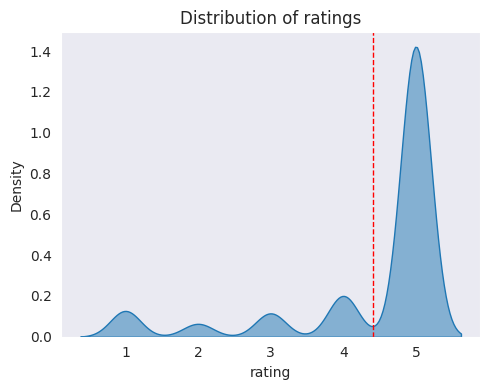

In [37]:
# Distribution of ratings
sns.set_style('dark', {'axes.grid':False})

plt.figure(figsize=(5,4))
# _ = sns.histplot(data=df, x='rating', color='teal', bins=5, kde=True)
_ = sns.kdeplot(data=df, x='rating', fill=True, alpha=0.5)
_.set_title('Distribution of ratings')
plt.axvline(x=df['rating'].mean(), ls='--', linewidth=1, color='red')
plt.tight_layout()
plt.show()

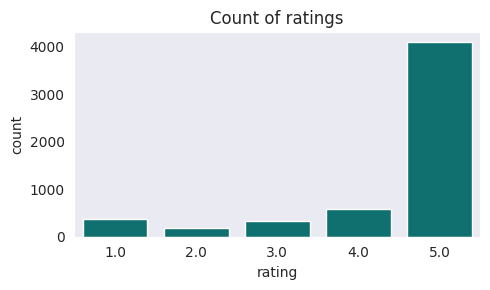

In [38]:
# Count Ratings
# sns.set_style('dark', {'axes.grid':False})
plt.figure(figsize=(5,3))
_ = sns.countplot(data=df, x='rating', color='teal')
_.set_title('Count of ratings')
plt.tight_layout()
plt.show()

#### Top Main Categories

In [39]:
# Set n results to extract and display
n_result = 10

In [40]:
# Top 10 Categories
vc_categories = pd.DataFrame(df['main_category'].value_counts()).reset_index()
vc_categories[0:n_result]

,main_category,count
0,Amazon Home,4416
1,Appliances,586
2,Grocery,545
3,Tools & Home Improvement,18
4,Industrial & Scientific,1
5,All Beauty,1


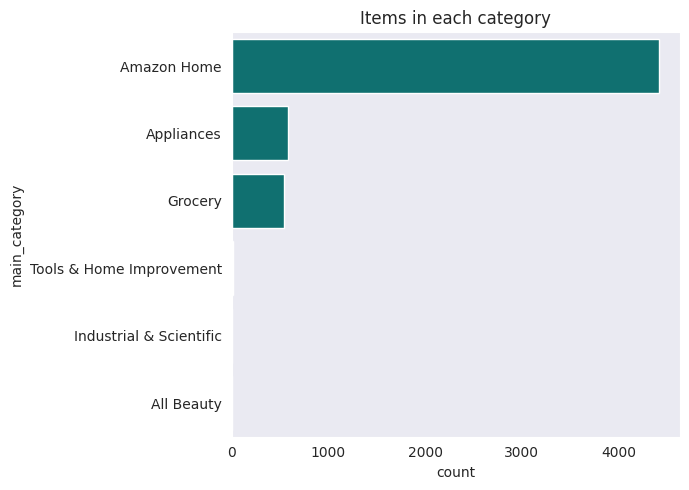

In [41]:
# Plot categories
sns.set_style('dark', {'axes.grid':False})
plt.figure(figsize=(7,5))

_ = sns.barplot(data=vc_categories, y='main_category', x='count', color='teal')
_.set_title('Items in each category')
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-warning">
Extracting True Categories:<br>
Use Text Classfication of LLMs to tidy up the categories. 
Decide whether to drop the null ASINs (in meta but not in reviews)
Set a mininmum no. of items for that category to be considered as a major category.
</div>

#### Extracting Subcategory

In [42]:
# Extract the last category in the list values in [categories] 
df_meta['subcategory'] = df_meta['categories'].apply(lambda x: x[-1] if len(x) else None)
df_meta.subcategory.isna().sum()

np.int64(2)

In [43]:
# If [categories] is empty, assign value from [main_category]
df_meta.subcategory.fillna(df_meta['main_category'], inplace=True)
df_meta.subcategory.isna().sum()

/tmp/ipykernel_42488/427950065.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_meta.subcategory.fillna(df_meta['main_category'], inplace=True)


np.int64(0)

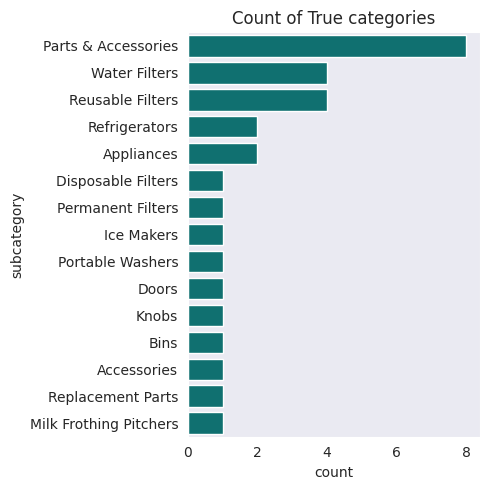

In [44]:
# Plot subcategories

vc_subcategory = df_meta.subcategory.value_counts().reset_index()

plt.figure(figsize=(5,5))
_ = sns.barplot(data=vc_subcategory, y='subcategory', x='count', color='teal')
_.set_title('Count of True categories')
plt.tight_layout()
plt.show()

In [45]:
# Drop the categories column with dictionary values
df_meta.drop('categories', axis=1, inplace=True)

### Content-Based Filtering

### Recommending Top Rated Items - A solution to Cold-Start problem

In [46]:
# Re-merge updated meta with ratings

df = df_ratings.merge(df_meta, how='left', on='parent_asin')
df.head(5)

,rating,asin,parent_asin,user_id,main_category,title,features,description,store,details,subcategory
0,5,B00LGEKOMS,B07RNJY499,AEDTXOC3YW6O7P2UPM22VNNRF77A,Amazon Home,iPartPlusMore Reusable Coffee Filters Compatib...,[ECO-ALTERNATIVE COFFEE FILTERS: Save up to 80...,[],iPartsPlusMore,"{'Product Dimensions': '1 x 1 x 1 inches', 'It...",Reusable Filters
1,5,B01DP1IWKU,B092LLM7H3,AE6DFDMIJAVW57EVMRJH2M2X6ACA,Grocery,Reusable coffee pods for Coffee Makers (4 PACK...,[],[],Delibru,{'Product Dimensions': '3.94 x 1.97 x 3.94 inc...,Reusable Filters
2,4,B000DLB2FI,B000DLB2FI,AEVGR67KN3CT4TO5D6HO3WNZGRPA,Amazon Home,Keurig My K-Cup Reusable Coffee Filter - Old M...,[Rinse clean under running water after each us...,[Keurig 5048 My K-Cup Reusable Coffee Filter -...,Keurig,"{'Product Dimensions': '3 x 3 x 5 inches', 'It...",Reusable Filters
3,5,B0001IRRLQ,B0BHNSLKNZ,AFLEUJNQJQOYOYDUJ2PSZ4O2TUJA,Amazon Home,"Cuisinart Replacement Water Filters, 2-Pack",[Made of nonwoven polyester and activated char...,"[Product Description, Make sure you're brewing...",Cuisinart,"{'Material': 'Man-made-material', 'Product Dim...",Permanent Filters
4,5,B00LGEKOMS,B07RNJY499,AEOVCZC77QZJQPBIAIKCFV7AS7PA,Amazon Home,iPartPlusMore Reusable Coffee Filters Compatib...,[ECO-ALTERNATIVE COFFEE FILTERS: Save up to 80...,[],iPartsPlusMore,"{'Product Dimensions': '1 x 1 x 1 inches', 'It...",Reusable Filters


In [47]:
df.shape

(5547, 11)

#### Top 10 Frequently rated

In [48]:
# Top 10 Frequently Rated
n_result = 10
df_most_rated = pd.DataFrame(df[['parent_asin', 'title', 'main_category', 'subcategory']].value_counts()[0:n_result]).reset_index()
df_most_rated

,parent_asin,title,main_category,subcategory,count
0,B07RNJY499,iPartPlusMore Reusable Coffee Filters Compatib...,Amazon Home,Reusable Filters,1329
1,B0B3DB5HTC,12 Pack Keurig Filter Replacement by K&J - Com...,Amazon Home,Disposable Filters,1220
2,B000DLB2FI,Keurig My K-Cup Reusable Coffee Filter - Old M...,Amazon Home,Reusable Filters,681
3,B0BHNSLKNZ,"Cuisinart Replacement Water Filters, 2-Pack",Amazon Home,Permanent Filters,605
4,B07P3Y8JWY,Disposable Paper Coffee Filters 600 count - Co...,Amazon Home,Reusable Filters,577
5,B0045LLC7K,Frigidaire WF3CB Puresource3 Refrigerator Wate...,Appliances,Water Filters,574
6,B092LLM7H3,Reusable coffee pods for Coffee Makers (4 PACK...,Grocery,Reusable Filters,545
7,B01IAFNZGC,EXCELPURE 5231JA2006A Replacement for LG LT600...,Tools & Home Improvement,Water Filters,10
8,B0BJ2CJTB5,Mini Washing Machine Portable Turbine Washer w...,Appliances,Portable Washers,5
9,B01DMRHDZ2,ClimaTek Gas Oven Range Stove Ignitor Igniter ...,Industrial & Scientific,Parts & Accessories,1


#### Top 10 Highly Rated

In [49]:
# Sort ratings then count. Not the ideal way to 

prod_stats = df.groupby(['parent_asin', 'title', 'main_category', 'subcategory'])['rating']\
        .agg(['count', 'mean'])\
        .reset_index()\
        .sort_values(['mean', 'count'], ascending=False)

prod_stats.head(n_result)

,parent_asin,title,main_category,subcategory,count,mean
3,B01IAFNZGC,EXCELPURE 5231JA2006A Replacement for LG LT600...,Tools & Home Improvement,Water Filters,10,5.000000
7,B0B3DB5HTC,12 Pack Keurig Filter Replacement by K&J - Com...,Amazon Home,Disposable Filters,1220,4.890984
6,B092LLM7H3,Reusable coffee pods for Coffee Makers (4 PACK...,Grocery,Reusable Filters,545,4.502752
8,B0BHNSLKNZ,"Cuisinart Replacement Water Filters, 2-Pack",Amazon Home,Permanent Filters,605,4.419835
1,B0045LLC7K,Frigidaire WF3CB Puresource3 Refrigerator Wate...,Appliances,Water Filters,574,4.397213
5,B07RNJY499,iPartPlusMore Reusable Coffee Filters Compatib...,Amazon Home,Reusable Filters,1329,4.263356
4,B07P3Y8JWY,Disposable Paper Coffee Filters 600 count - Co...,Amazon Home,Reusable Filters,577,4.235702
0,B000DLB2FI,Keurig My K-Cup Reusable Coffee Filter - Old M...,Amazon Home,Reusable Filters,681,3.979442
9,B0BJ2CJTB5,Mini Washing Machine Portable Turbine Washer w...,Appliances,Portable Washers,5,1.400000
2,B01DMRHDZ2,ClimaTek Gas Oven Range Stove Ignitor Igniter ...,Industrial & Scientific,Parts & Accessories,1,1.000000


##### Calculating Bayesian Average of Ratings

In [50]:
# c_confidence:  typical dataset size or average number(or count) of ratings for a given movie
c_confidence = prod_stats['count'].mean()

# m_priori :  mean rating across all products
m_priori = prod_stats['mean'].mean()

print(f'Confidence : {c_confidence}')
print(f'Priori: {m_priori}')

Confidence : 554.7
Priori: 3.808928296460555


In [51]:
def bayesian_average(l_ratings):
    """
    Calculate the Bayesian average rating for a product.
    Args:
        l_ratings (pd.Series): Series of ratings for a product.
    Returns:
        float: Bayesian average rating.
    """
    bayes_avg =  ( (c_confidence * m_priori) + l_ratings.sum() )/ ( c_confidence + l_ratings.count())
    return round(bayes_avg, 3)

In [52]:
# Get the bayesian average in prod_stats
bayesian_ratings = df.groupby(['asin', 'main_category', 'subcategory', 'title'])['rating'].agg(bayesian_average).reset_index().sort_values('rating', ascending=False)
bayesian_ratings[0:n_result]

,asin,main_category,subcategory,title,rating
14,B01DLEL4EM,Amazon Home,Disposable Filters,12 Pack Keurig Filter Replacement by K&J - Com...,4.485
17,B01GAGM62M,Amazon Home,Disposable Filters,12 Pack Keurig Filter Replacement by K&J - Com...,4.185
16,B01DP1IWKU,Grocery,Reusable Filters,Reusable coffee pods for Coffee Makers (4 PACK...,4.149
8,B0045LLC7K,Appliances,Water Filters,Frigidaire WF3CB Puresource3 Refrigerator Wate...,4.108
11,B00LGEKOMS,Amazon Home,Reusable Filters,iPartPlusMore Reusable Coffee Filters Compatib...,4.036
1,B0001IRRLG,Amazon Home,Permanent Filters,"Cuisinart Replacement Water Filters, 2-Pack",4.011
10,B00BUFJBQS,Amazon Home,Reusable Filters,Disposable Paper Coffee Filters 600 count - Co...,4.009
13,B01AUBYMK2,Amazon Home,Reusable Filters,iPartPlusMore Reusable Coffee Filters Compatib...,3.963
6,B000TETMVK,Amazon Home,Permanent Filters,"Cuisinart Replacement Water Filters, 2-Pack",3.950
19,B06X9RFT2J,Amazon Home,Reusable Filters,iPartPlusMore Reusable Coffee Filters Compatib...,3.946


#### Feature Text Preparation

In [53]:
df_meta.isna().sum()

main_category    0
title            0
features         0
description      0
store            0
details          0
parent_asin      0
subcategory      0
dtype: int64

Feature Texts = ASIN + TITLE + DETAILS['Brand or Manufacturer]

In [54]:
# Backup meta
df_meta_c = df_meta.copy(deep=True)

In [55]:
# Create new column [maker] and assign/extract brand or manufacturer from {details} 
df_meta['maker'] = df_meta['details'].apply(lambda x: x.get('Brand') if not x else x.get('Manufacturer'))

In [56]:
# If [details] have no dict{} values, assign the [store] value
df_meta.maker.fillna(df_meta['store'], inplace=True)
df_meta.maker.isna().sum()

/tmp/ipykernel_42488/3128023141.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_meta.maker.fillna(df_meta['store'], inplace=True)


np.int64(0)

In [57]:
df_meta[['main_category', 'title', 'store', 'maker']].head()

,main_category,title,store,maker
0,Amazon Home,"Cuisinart Replacement Water Filters, 2-Pack",Cuisinart,Cuisinart
1,Amazon Home,12 Pack Keurig Filter Replacement by K&J - Com...,K&J,K&J
2,Grocery,Reusable coffee pods for Coffee Makers (4 PACK...,Delibru,Delibru
3,Amazon Home,Disposable Paper Coffee Filters 600 count - Co...,SIMPLECUPS,Simple Cups
4,Amazon Home,iPartPlusMore Reusable Coffee Filters Compatib...,iPartsPlusMore,iPartsPlusMore


#### Word counts

Analyze the word counts in title, description, store and details.


In [58]:
# Transform [description] and features list to a stream of str 
df_meta['description'] = df_meta['description'].apply(lambda x: ' '.join(x))
df_meta['features'] = df_meta['features'].apply(lambda x: ' '.join(x))

In [59]:
# Drop categories and details - for now
df_meta.drop('details', axis=1, inplace=True)

In [60]:
# cols_object = df_meta.select_dtypes(include='object').columns
cols_object = ['title', 'description', 'features']

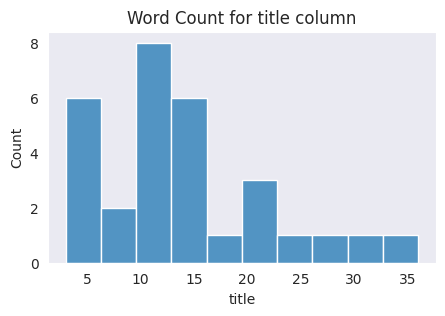

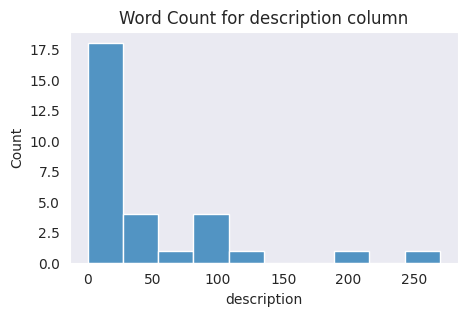

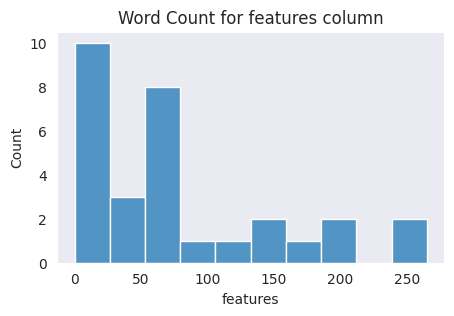

In [61]:
# Count words for columns of interests.
for col in cols_object:

    word_ct = df_meta[col].str.split().str.len()

    sns.set_style('dark')
    plt.figure(figsize=(5,3))

    hist = sns.histplot(x=word_ct, bins=10)
    hist.set_title(f'Word Count for {col} column')
    plt.show()

#### Processing Outliers

There's products with extremely long description.\
What to do with the outliers?\
If we are to identify the outliers, we need to create columns that will store word counts per column.

In [62]:
# # UDF: Function for extracting outliers and non-outliers from a dataframe

# def process_outliers(data_df: pd.DataFrame, col: str, is_outlier = True) -> pd.DataFrame:
#     '''Desc: Custom function for extracting outliers or non-outliers depending on the is_outlier argument.
    
#     Input: 
#         data_df: pd.DataFrame - dataframe to process
#         col: str - column to process
#         is_outlier: bool - If True (by default) will extract outliers; otherwise, non-outliers'''
    
#     q1 = data_df[col].quantile(0.25)
#     print('q1:', q1)
#     q3 = data_df[col].quantile(0.75)
#     print('q3:', q3)
#     iqr = q3 - q1
#     if is_outlier:
#         result = data_df[((data_df[col] < (q1 - 1.5 * iqr)) | (data_df[col] > (q3 + 1.5 * iqr)))] #.any(axis=1)]
#     else:
#         result = data_df[~((data_df[col] < (q1 - 1.5 * iqr)) | (data_df[col] > (q3 + 1.5 * iqr)))] #.any(axis=1)]
        
#     return result

In [63]:
# df_meta['wc_description'] = df_meta['description'].str.split().str.len()
# df_meta['wc_store'] = df_meta['store'].str.split().str.len()
# df_meta['wc_features'] = df_meta['features'].str.split().str.len()
# df_meta['wc_title'] = df_meta['title'].str.split().str.len()

In [64]:
# cols_numeric = df_meta.select_dtypes(include='number').columns

# for col in cols_numeric:
    
#     sns.set_style('dark')
#     plt.figure(figsize=(5,2))
#     box = sns.boxplot(data=df_meta, x=col)
#     box.set_title(f'Distribution for {col} column')
#     plt.show()

In [65]:
# # Products with long description that are outliers

# df_ol_desc = process_outliers(df_meta, 'wc_description', is_outlier=True)
# df_ol_desc.sort_values('wc_description', ascending=False)

In [66]:
# # Percentage of outliers with long description

# len(df_ol_desc)*100/len(df_meta)

In [67]:
# df_ol_store = process_outliers(df_meta, 'wc_store', is_outlier=True)
# len(df_ol_store)*100/len(df_meta)

In [68]:
# df_ol_title = process_outliers(df_meta, 'wc_title', is_outlier=True)
# len(df_ol_title)*100/len(df_meta)

In [69]:
# df_ol_dets = process_outliers(df_meta, 'wc_details', is_outlier=True)
# len(df_ol_dets)*100/len(df_meta)

## PRE-PROCESSING

##### Prep [details] and [store] for feature group in merged dataframe

> Note: For feature group [parent_asin] was used as products that have not been reviewed does not have a corresponding [asin]

In [70]:
df_meta.head()

,main_category,title,features,description,store,parent_asin,subcategory,maker
0,Amazon Home,"Cuisinart Replacement Water Filters, 2-Pack",Made of nonwoven polyester and activated charc...,Product Description Make sure you're brewing t...,Cuisinart,B0BHNSLKNZ,Permanent Filters,Cuisinart
1,Amazon Home,12 Pack Keurig Filter Replacement by K&J - Com...,PERFECT FIT - These Keurig-compatible replacem...,,K&J,B0B3DB5HTC,Disposable Filters,K&J
2,Grocery,Reusable coffee pods for Coffee Makers (4 PACK...,,,Delibru,B092LLM7H3,Reusable Filters,Delibru
3,Amazon Home,Disposable Paper Coffee Filters 600 count - Co...,"Compatible with Solofill, Solo Filters, EZ-Cup...",,SIMPLECUPS,B07P3Y8JWY,Reusable Filters,Simple Cups
4,Amazon Home,iPartPlusMore Reusable Coffee Filters Compatib...,ECO-ALTERNATIVE COFFEE FILTERS: Save up to 80%...,,iPartsPlusMore,B07RNJY499,Reusable Filters,iPartsPlusMore


In [71]:
# Select the features to be used for NLP

selected_features = ['parent_asin',  'main_category', 'subcategory', 'maker', 'title']
# selected_features = ['parent_asin', 'title', 'store', 'details']
# removed [store][details] due to resource issues - Unable to allocate 31.4 GiB for an array with shape (4220106037,) and data type int64.

# df['feature_group'] = df[selected_features].apply(lambda x: ' '.join(x))
df_meta['feature_group'] = df_meta[selected_features].agg(' '.join, axis=1)
df_meta.head(2)

,main_category,title,features,description,store,parent_asin,subcategory,maker,feature_group
0,Amazon Home,"Cuisinart Replacement Water Filters, 2-Pack",Made of nonwoven polyester and activated charc...,Product Description Make sure you're brewing t...,Cuisinart,B0BHNSLKNZ,Permanent Filters,Cuisinart,B0BHNSLKNZ Amazon Home Permanent Filters Cuisi...
1,Amazon Home,12 Pack Keurig Filter Replacement by K&J - Com...,PERFECT FIT - These Keurig-compatible replacem...,,K&J,B0B3DB5HTC,Disposable Filters,K&J,B0B3DB5HTC Amazon Home Disposable Filters K&J ...


### Find Similar Products

In [72]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /home/edu/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/edu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [73]:
# Testing purposes - flag token/lemma
flag_token = False
flag_lemma = False

In [74]:
# NLP Objects and parameters
wnl = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

#### NLP UDFs

In [76]:
def preprocess_text(text):
    """
    Preprocesses the input text by removing special characters, converting to lowercase,
    removing stop words, and applying stemming or lemmatization.

    Args:
        text (str): Input text to preprocess.
        flag_token (bool): If True, tokenizes the text. Defaults to False.

    Returns:
        str: Preprocessed text.
    """
    
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
        
    return text

In [77]:
def tokenizer(txt):
    """
    Tokenizes the input text by removing stop words and applying stemming or lemmatization.
    Flags to indicate if tokenization is set to True. 

    Args:
        txt (str): Input text to tokenize.
    Returns:
        list: List of tokens.
    """

    global flag_token
    word_tokens = nltk.word_tokenize(txt)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    flag_token = True
        # filtered_text = [stemmer.stem(text) for text in filtered_sentence]
  
        # return ' '.join(filtered_text)
    
    return filtered_sentence

In [78]:
def lemmatizer(txt):
    """
    Lemmatizes the input text by removing stop words and applying stemming or lemmatization.
    Flags to indicate if lemmatization is set to True.
    Args:
        txt (str): Input text to lemmatize.
    Returns:
        str: Lemmatized text.
    """
    
    global flag_lemma

    filtered_text = [wnl.lemmatize(text) for text in txt]
    flag_lemma = True
    
    return ' '.join(filtered_text)

#### Apply the NLP Functions to pre-process, tokenize, lemmatize texts

In [79]:
# Apply preprocessing to the feature group
df_meta['feature_group'] = df_meta['feature_group'].apply(preprocess_text)

In [80]:
# Apply custom tokenizer to feature_group column# Apply custom tokenizer to feature_group column
df_meta['feature_group'] = df_meta['feature_group'].apply(lambda x: tokenizer(x))

In [81]:
# Apply lemmatizer to feature_group column
df_meta['feature_group'] = df_meta['feature_group'].apply(lambda x: lemmatizer(x))

#### Vectorize the text

In [82]:
# Create a csr matrix
vectorizer = TfidfVectorizer(analyzer='word',stop_words='english')
feature_vectors = vectorizer.fit_transform(df_meta['feature_group'].values)

In [83]:
print(len(vectorizer.get_feature_names_out())) 

282


In [84]:
print(feature_vectors)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 447 stored elements and shape (30, 282)>
  Coords	Values
  (0, 66)	0.3257230282117321
  (0, 31)	0.1855857897294682
  (0, 150)	0.12969818423540308
  (0, 212)	0.3257230282117321
  (0, 128)	0.33942131523625463
  (0, 100)	0.6514460564234642
  (0, 227)	0.19475975760687753
  (0, 268)	0.23006448114557898
  (0, 9)	0.3257230282117321
  (1, 31)	0.1497597127927342
  (1, 150)	0.10466083016995628
  (1, 128)	0.27389833434775257
  (1, 227)	0.1571627084450055
  (1, 62)	0.2628444086482938
  (1, 111)	0.23435502233757408
  (1, 168)	0.5256888172965876
  (1, 2)	0.23435502233757408
  (1, 210)	0.1856520947557252
  (1, 166)	0.39692528074916616
  (1, 91)	0.17482093276462413
  (1, 87)	0.17482093276462413
  (1, 181)	0.1856520947557252
  (1, 5)	0.23435502233757408
  (1, 206)	0.2628444086482938
  (2, 128)	0.1575059806162777
  :	:
  (28, 215)	0.45568775204979983
  (28, 80)	0.3037918346998666
  (28, 209)	0.1518959173499333
  (28, 123)	0.3037918346998666
 

In [ ]:
# Verify
feature_vectors.shape

(30, 282)

#### Calculate Cosine Similarity

In [86]:
# Calculate cosine similarity
similarity = cosine_similarity(feature_vectors)
similarity.shape

(30, 30)

In [87]:
# Set display option 
pd.options.display.max_colwidth = 1000

#### Option A: Similar items using ASIN

In [88]:
def get_product_data(query:str , data_df: pd.DataFrame, col: str) : # -> pd.DataFrame:
    """UDF: get_product_data using query
    Args:
        query (str): Search query
        data_df (pd.DataFrame): DataFrame to search in
        col (str): Column to search in
    Returns:
        pd.DataFrame: DataFrame containing the search results
    """
    
    # Search using exact query
    l_data = data_df[data_df[col] == query] 

    if len(l_data) == 1:
        print('Exact product match used in query.')
    
    # If not exact, refine search...
    else:

        query = re.sub(r'[^a-zA-Z0-9\s]', '', query)
        l_data = data_df[data_df['title']\
                  .apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))\
                  .str.lower()
                  .str.contains(query.lower())\
                    ]

        # If refined query matches one or more product names
        if len(l_data) > 0:
            print('Found products with similar keywords.')

        else:            
            print('No products matched the keywords in query. Try again.')
          
    return l_data


In [89]:
def get_product_index(data_df: pd.DataFrame, query:str, col: str) -> int:
    """
    Get the index of the product in the DataFrame based on the query.
    Args:
        data_df (pd.DataFrame): DataFrame containing product data.
        query (str): Query string to search for.
        col (str): Column name to search in.
    Returns:
        int: Index of the product in the DataFrame.
    """

    product_index = data_df[data_df[col] == query].index
    return product_index[0] if len(product_index) > 0 else None

In [90]:
def recommend_similar_products(query: str, data_df: pd.DataFrame, cos_sim: np.array, n_result: int = 1):
    """
    Recommend similar products based on the query and cosine similarity.
    Args:
        query (str): Search query.
        data_df (pd.DataFrame): DataFrame containing product data.
        cos_sim (np.array): Cosine similarity matrix.
        n_result (int): Number of similar products to recommend. Defaults to 1.
    Returns:
        list: List of similar products with their IDs and titles.
    """

    l_prods = get_product_data(query, data_df, 'title')
    
    if len(l_prods) > 0:

        top_idx = l_prods.index[0]
        distances = sorted(list(enumerate(cos_sim[top_idx])), reverse=True, key=lambda x:x[1])

        similar_items = []

        # Assumptions: 
        #    l_prods.size == 1: Exact product_name match or passed via pre-loaded drop_down list
        #    l_prods.size > 1 : Generic keyword search returned multiple matches

        ret_begin_idx = 0

        if l_prods.size == 1:  # exclude the first item in the distances list
            ret_begin_idx = 1
            n_result += 1
        
        # Iterate over distances
        for p_id in distances[ret_begin_idx:(n_result)]: 
            
            similar_items.append({'id': data_df.iloc[p_id[0]].parent_asin, 'title': data_df.iloc[p_id[0]].title})

    return similar_items

In [91]:
# # UT:: Test get prod index
# idx = get_product_index(df_meta, query, 'title')
# print(f'Index of product in DataFrame: {idx}')

In [92]:
# # UT: Test function get_product_data
# x = get_product_data(query, df_meta, 'title')
# print(x.index[0])

##### Input using Prod ID or Text

In [75]:
# Try
query = 'Washing Machine'
# query = 'Keurig My K-Cup Reusable Coffee Filter - Old Model'

##### Recommend

In [93]:
# Call fuction: recommend_similar_products
list_recos = recommend_similar_products(query, df_meta, similarity, n_result)

if list_recos:
    print(f'Recommending {len(list_recos)} items similar to your query')

Found products with similar keywords.
Recommending 10 items similar to your query


In [94]:
# Convert the Top N list to DataFrame
df_recos = pd.DataFrame(list_recos)
df_recos

,id,title
0,B0BJ2CJTB5,"Mini Washing Machine Portable Turbine Washer with USB for Travel Business Trip or College Rooms (Speed Control Model), White, 1pack"
1,B00IIH5CRS,Samsung DC92-01040B Washer Electronic Control Board Genuine Original Equipment Manufacturer (OEM) Part
2,B07S9DJ2S2,"Frigidaire Portable Compact Maker, Counter Top Ice Making Machine, 26lb per day (Blue) (EFIC108-BLUE) (Renewed)"
3,B0045LLC7K,"Frigidaire WF3CB Puresource3 Refrigerator Water Filter , White, 1 Count (Pack of 1)"
4,B08VHW1WQW,Supplying Demand WR9X520 WR09X0520 Refrigerator Defrost Timer Replacement Model Specific Not Universal
5,B01FIHH4MG,"Fire Magic Vent Hood Duct Cover - 42"""
6,B0B5V1VTX1,"MANWU 2 sets flame indicators ring stove sticker decal label for burner cooktop hob cooker top markings oven replacement adhesive knob symbols (for Silver, White or Light Coloured stove)"
7,B000DLB2FI,Keurig My K-Cup Reusable Coffee Filter - Old Model
8,B01N638EFK,Shark XHF350 Navigator Lift Away NV350 NV351 NV352 Replacement HEPA Filter- by Allergy Be Gone
9,B09P6MFM2F,"(OCN) New AP3885460 PS1145040 Range Stove Element Burner Switch Compatible with Frigidaire 316436001 1155395, 316021501, AH1145040 fit many other models"


#### Option B: Similar items using query

- Transform the query using the same vocabulary from the previous fit step on the corpus.
- Calculate the pairwise cosine similarities between each document in the corpus and the query.
- Sort them in descending order by score

In [96]:
def get_query_tfidf(tfidf_vectorizer: TfidfVectorizer, query:str) -> np.ndarray:
    """
    Get the TF-IDF vector for the query.
    Args:
        data_df (pd.DataFrame): DataFrame containing product data.
        query (str): Query string to search for.
        col (str): Column name to search in.
    Returns:
        np.ndarray: TF-IDF vector for the query.
    """
    
    formatted_query = preprocess_text(query) 
    formatted_query = tokenizer(formatted_query)
    formatted_query = lemmatizer(formatted_query)
    # formatted_query = formatted_query.split()
    query_vector = tfidf_vectorizer.transform([formatted_query])
    
    return query_vector

In [97]:
def top_k(arr_cosim, k=1):
    """
    Get the indices of the top k elements in an array.
    Args:
        arr (np.ndarray): Input array.
        k (int): Number of top elements to retrieve. Defaults to 1.
    Returns:
        list: List of indices of the top k elements.
    """
    kth_largest = (k+1) * -1
    return np.argsort(arr_cosim)[:kth_largest:-1]

##### Input using search query/text

In [ ]:
query = 'Coffee'
# query = 'Keurig My K-Cup Reusable Coffee Filter - Old Model'

##### Process query

In [98]:
# Get the tfidf vector for the query
query_tfidf = get_query_tfidf(vectorizer, query)
query_tfidf.shape

(1, 282)

In [99]:
# Compute cosine similarity between the query and feature vectors
cosine_similarites = cosine_similarity(query_tfidf, feature_vectors).flatten()

In [100]:
# Get top k indices
top_indices = top_k(cosine_similarites, n_result)
print(f'Top {n_result} indices: {top_indices}')

Top 10 indices: [ 5  1 10  3 28 29 23 22 21 20]


In [101]:
# Display the top k results
df_meta.iloc[top_indices][['parent_asin', 'main_category', 'subcategory', 'maker', 'title' ]]

,parent_asin,main_category,subcategory,maker,title
5,B0BJ2CJTB5,Appliances,Portable Washers,Homesweety,"Mini Washing Machine Portable Turbine Washer with USB for Travel Business Trip or College Rooms (Speed Control Model), White, 1pack"
1,B0B3DB5HTC,Amazon Home,Disposable Filters,K&J,12 Pack Keurig Filter Replacement by K&J - Compatible with Keurig Coffee Machine (2.0 and older)
10,B07S9DJ2S2,Amazon Home,Ice Makers,Amazon Renewed,"Frigidaire Portable Compact Maker, Counter Top Ice Making Machine, 26lb per day (Blue) (EFIC108-BLUE) (Renewed)"
3,B07P3Y8JWY,Amazon Home,Reusable Filters,Simple Cups,"Disposable Paper Coffee Filters 600 count - Compatible with Keurig, K-Cup machines & other Single Serve Coffee Brewer Reusable K Cups - Use Your Own Coffee & Make Your Own Pods - Works with All Brands"
28,B0BD2MT2FN,Amazon Home,Milk Frothing Pitchers,CACAKEE,"CACAKEE Milk Frothing Pitcher, 12 OZ/350ML Stainless Steel Espresso Steaming Pitchers, Coffee Milk Frother Jug for Espresso Machines Cappuccino Latte Art, Pour Cup"
29,B07DHXZFXV,Appliances,Refrigerators,LG,LG LSXC22396D 22 Cu. Ft. Black Stainless InstaView Counter Depth Side-by-Side Refrigerator
23,B002AFBAKW,Appliances,Refrigerators,Whirlpool,Whirlpool : ED5LHAXWB 25 cu. ft. Side-by-Side Refrigerator - Black
22,B001HO55EY,Tools & Home Improvement,Parts & Accessories,GE,GE WB06X10541 Wave Guide Cover
21,B09P6MFM2F,All Beauty,Accessories,CYOIDAI,"(OCN) New AP3885460 PS1145040 Range Stove Element Burner Switch Compatible with Frigidaire 316436001 1155395, 316021501, AH1145040 fit many other models"
20,B01FIHH4MG,Appliances,Appliances,Fire Magic,"Fire Magic Vent Hood Duct Cover - 42"""
